In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
def check_season_data(league, season):
    season_dir = f'{league}_{season}'
    data = []
    for sheet in os.listdir(f'data/{season_dir}'):
        temp = pd.read_csv(f'data/{season_dir}/{sheet}').tail(3)
        data.append([sheet.strip('.csv'), temp['W-L'].values[0]])
    df = pd.DataFrame(data, columns=['Team', 'Record'])
    df['W'] = df['Record'].apply(lambda x: x.split('-')[0]).apply(int)
    df['L'] = df['Record'].apply(lambda x: x.split('-')[1]).apply(int)
    df['W%'] = df['W'] / (df['W'] + df['L'])
    return df.sort_values('W%', ascending=False).drop(['W', 'L'], axis=1)

In [5]:
def calculate_pace(team_df):
    temp = team_df.to_dict(orient='records')
    team_records = {'Team': [temp[i] for i in range(3)
                             if temp[i]['Player'] == 'Total'][0],
                    'Opponent': [temp[i] for i in range(3)
                                 if temp[i]['Player'] == 'Opponents'][0]}
    total_poss = 0
    for side in ['Team']: #, 'Opponent']:
        total_poss += team_records[side]['FGA'] - \
                      team_records[side]['Or'] + \
                      team_records[side]['To'] + \
                      0.44 * team_records[side]['FTA']

    return total_poss, team_records['Team']['MIN'] / 5

In [6]:
def process_team_sheet(team_sheet, season_dir):
    # Initial Process
    df = pd.read_csv(f'data/{season_dir}/{team_sheet}')\
           .drop('W-L', axis=1)
    
    shooting_cols = ['2P', '3P', 'FG', 'FT']
    for col in shooting_cols:
        df[f'{col}M'] = df[col].apply(lambda x: x.split('/')[0])\
                               .apply(int)
        df[f'{col}A'] = df[col].apply(lambda x: x.split('/')[1])\
                               .apply(int)
    df.drop(shooting_cols + [col for col in df.columns
                             if '.1' in col], 
            inplace=True, axis=1)
    df['Dr'] = df['Reb'] - df['Or']
    
    league, season = season_dir.split('_')
    season_dir_ps = f'{league} Play-Offs_{season}'
    df_ps_exist = False
    if team_sheet in os.listdir(f'data/{season_dir_ps}'):
        df_ps_exist = True
        df_ps = pd.read_csv(f'data/{season_dir_ps}/{team_sheet}')\
                  .drop('W-L', axis=1)
        for col in shooting_cols:
            df_ps[f'{col}M'] = df_ps[col].apply(lambda x: x.split('/')[0])\
                                         .apply(int)
            df_ps[f'{col}A'] = df_ps[col].apply(lambda x: x.split('/')[1])\
                                         .apply(int)
        df_ps.drop(shooting_cols + [col for col in df.columns
                                    if '.1' in col], 
                   inplace=True, axis=1)
        df_ps['Dr'] = df_ps['Reb'] - df_ps['Or']
        
    
    # Calculate pace
    team_df = df.tail(3).copy()
    if df_ps_exist:
        team_df_ps = df_ps.tail(3).copy()
        team_df = pd.concat([team_df, team_df_ps])\
                    .drop(['Height', 'Age'], axis=1)\
                    .groupby(['Player', 'Team'])\
                    .sum().reset_index()
    team_poss, team_min = calculate_pace(team_df)
    
    # Get Estimates of players' possessions
    if df_ps_exist:
        df = pd.concat([df, df_ps])\
               .groupby(['Player', 'Height', 'Age', 'Team'])\
               .sum().reset_index()
    df = df[~df['Height'].isna()]
    df['Poss_est'] = df['MIN'] / team_min * team_poss
    
    return df

In [7]:
def process_season_sheets(season, league):
    season_dir = f'{league}_{season}'
    dfs = [process_team_sheet(team_sheet, season_dir)
           for team_sheet in os.listdir(f'data/{season_dir}/')
           if '.csv' in team_sheet]
    df = pd.concat(dfs).reset_index(drop=True)
    df['season'] = season
    return df

## Process Eurocup

In [8]:
league = 'China - CBA'

In [9]:
seasons = list(range(2018, 2022))

In [10]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2021
# check_season_data(league, 2021)

In [11]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2020
# check_season_data(league, 2020)

In [12]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2019
# check_season_data(league, 2019)

In [13]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2018
# check_season_data(league, 2018)

In [14]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2017
# check_season_data(league, 2017)

In [20]:
df = pd.concat([process_season_sheets(season, league)
                for season in seasons])\
       .reset_index(drop=True)
df.shape

(1430, 29)

<Axes: >

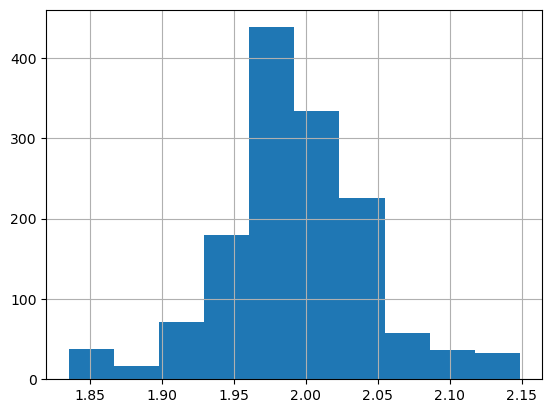

In [21]:
(df['Poss_est'] / df['MIN']).hist()

In [17]:
df.to_csv('proballers_cba_stats.csv', index=False)

In [18]:
del df

### Merge with Synergy

In [42]:
team_dict = {
    'shandong': 'Shandong Hi-Speed Golden Stars',
    'beikong-royal-fighters': 'Beijing Beikong Royal Fighters (Fly Dragons)',
    'guangzhou-long-lions': 'Guangzhou Securities Long-Lions',
    'guangdong-southern-tigers': 'Guangdong Dongguan Bank',
    'shenzhen-aviators': 'Shenzhen Aviators',
    'xinjiang-flying-tigers': 'Xinjiang Tianshan R-C Bank Flying Tigers',
    'nanjing-tongxi-monkey-kings': 'Nanjing Tongxi Monkey Kings',
    'zhejiang-golden-bulls': 'Zhejiang Guangsha Lions', 
    'tianjin-pioneers': 'Tianjin Ronggang Gold Lions',
    'jilin-northeast-tigers': 'Jilin Northeast Tigers', 
    'shanghai-sharks': 'Shanghai Bilibili Sharks', 
    'qingdao-eagles': 'Qingdao DoubleStar Eagles',
    'fujian-sbs-xunxing-sturgeons': 'Fujian SBS Xunxing Sturgeons', 
    'beijing-ducks': 'Beijing Shougang Ducks', 
    'shanxi': 'Shanxi Fenjiu Brave Dragons',
    'liaoning-leopards': 'Liaoning Scale Industry Flying Leopards', 
    'sichuan-blue-whales': 'Sichuan Jinqiang Blue Whales', 
    'ningbo-rockets': 'Ningbo Bayi Rockets',
    'jiangsu-dragons': 'Jiangsu Dragons Knetier', 
    'zhejiang-lions': 'Zhejiang Guangsha Lions'    
}

In [441]:
# proballers_name_dict = {
#     "Johnny O'bryant": "Johnny O'Bryant",
#     'Antonio Crocker': 'Tony Crocker',
#     'Sam Van Rossom': 'Sam van Rossom',
#     'Pere Oriola': 'Pierre Oriola',
#     'Dennis Jerome Seeley': 'D.J. Seeley',
#     'Iffe Lundberg': 'Gabriel Lundberg',
#     'Viatcheslav Zaitsev': 'Vyacheslav Zaytsev',
#     'Zan Sisko': 'Zan Mark Sisko',
#     'John Di Bartolomeo': 'John DiBartolomeo',
#     'Efstratios Perperoglou': 'Stratos Perperoglou',
#     'Andrei Vorontsevich': 'Andrey Vorontsevich',
#     'Ali Muhammed': 'Bobby Dixon',
#     'Dmitry Uzinsky': 'Dmitrii Uzinskii',
#     'Egor Vialtsev': 'Egor Vyaltsev',
#     'Ibrahima Faye Fall': 'Ibrahima Fall Faye',
#     'Vasilis Charalampopoulos': 'Vassilis Charalampopoulos',
#     'Vasileios Kavvadas': 'Vassilis Kavvadas',
#     'Sandy Cohen III': 'Sandy Cohen',
#     'Santi Yusta': 'Santiago Yusta',
#     'Miguel Gonzalez Burgos': 'Miguel Gonzalez',
#     'Ergi Tirpanci': 'Efe Tirpanci'
# }

In [43]:
pb_df = pd.read_csv('proballers_cba_stats.csv')
pb_df['Season'] = pb_df['season'].apply(lambda x: f'{x}-{x+1}')
pb_df = pb_df.drop('season', axis=1)
pb_df['Team'] = pb_df['Team'].map(team_dict)
# pb_df['Player'] = pb_df['Player'].apply(lambda x: proballers_name_dict.get(x, x))
pb_df.head()

,Player,Height,Age,Team,Pts,Reb,Ast,GP,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM,FGA,FTM,FTA,Dr,Reb.1,Ast.1,Pts.1,Poss_est,Season
0,Andrew Goudelock,1m91,30.0,Shandong Hi-Speed Golden Stars,442,55,64,19,580,11,20,26,3,22,371,102,202,66,149,168,351,40,44,44,0.0,0.0,0.0,1149.639553,2018-2019
1,Cheng Jia,2m06,27.0,Shandong Hi-Speed Golden Stars,402,257,36,48,1017,78,23,53,30,141,508,131,261,19,51,150,312,83,108,179,6.0,4.0,9.0,2015.833493,2018-2019
2,Chunjun Zhang,1m97,31.0,Shandong Hi-Speed Golden Stars,230,143,62,40,1116,56,57,35,2,133,342,59,105,32,89,91,194,16,30,87,6.0,6.0,17.0,2212.065072,2018-2019
3,Donatas Motiejunas,2m13,28.0,Shandong Hi-Speed Golden Stars,1011,517,154,37,1246,118,67,106,30,95,1203,369,618,40,124,409,742,153,290,399,29.0,9.0,41.0,2469.742903,2018-2019
4,Hanlin Tao,2m08,27.0,Shandong Hi-Speed Golden Stars,549,273,30,48,1171,105,29,36,30,136,689,221,374,0,0,221,374,107,140,168,10.0,0.0,9.0,2321.082616,2018-2019


In [450]:
# synergy_name_dict = {
#     'Konstantinos Sloukas': 'Kostas Sloukas',
#     'Deshaun Thomas': 'DeShaun Thomas',
#     'Nando de Colo': 'Nando De Colo',
#     'Errick Mccollum': 'Errick McCollum',
#     'Kostas Mitoglou': 'Konstantinos Mitoglou',
#     'Oscar da Silva': 'Oscar Da Silva',
#     'Giorgios Papagiannis': 'Georgios Papagiannis',
#     'Nico Laprovittola': 'Nicolas Laprovittola',
#     'Eleftherios Bochoridis': 'Lefteris Bochoridis',
#     'Zan Sisko': 'Zan Mark Sisko',
#     'Micheal Eric': 'Michael Eric',
#     'Sergey Monya': 'Sergey Monia',
#     'Marko Jagodic Kuridza': 'Marko Jagodic-Kuridza',
#     'Timothy Abromaitis': 'Tim Abromaitis',
#     'OJ Mayo': 'O.J. Mayo',
#     'Derrick Walton Jr': 'Derrick Walton',
#     'Demarcus Nelson': 'DeMarcus Nelson',
#     'Thomas Bray': 'T.J. Bray',
#     'Vitaliy Fridzon': 'Vitaly Fridzon',
#     'Ibrahima Fall-Faye': 'Ibrahima Fall Faye',
#     'Charles Galliou-Loko': 'Charles Galliou',
#     'Josep Puerto': 'Joseph Puerto',
#     'Giorgos Kalaitzakis': 'Georgios Kalaitzakis',
#     'David Kraemer': 'David Kramer',
#     'Viacheslav Zaitcev': 'Vyacheslav Zaytsev',
#     'Amare Stoudemire': "Amar'e Stoudemire",
#     'Andrei Desyatnikov': 'Andrey Desiatnikov',
#     'Dmitriy Kadoshnikov': 'Dmitrii Kadoshnikov',
#     'Andrey Lopatin': 'Andrei Lopatin',
#     'Yonathan Atias': 'Yonatan Atias',
#     'Omercan Ilyasoglu': 'Omer Ilyasoglu'
# }

In [44]:
synergy_df = pd.read_csv('../data/CBA_offense.csv')
synergy_df = synergy_df[synergy_df['Season'] != '2017-2018']\
             .reset_index(drop=True)
synergy_df = synergy_df[synergy_df['Team'] != 'Shanxi Dongshen Kylins - old Guanghzou team do not use please']\
             .reset_index(drop=True)
synergy_df['Team'] = synergy_df['Team']\
                     .apply(lambda x: x 
                            if x != 'old team do not use Shenzhen Leopards'
                            else 'Shenzhen Aviators')
synergy_df['Player'] = synergy_df['Player']\
                       .apply(lambda x: x.strip(' ').replace('  ', ' '))
#                        .apply(lambda x: synergy_name_dict.get(x, x))
synergy_df.head()

,Player,Team,Season,GP,FGM,FGA,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt
0,Kenny Boynton,Shenzhen Aviators,2018-2019,54,459.0,888.0,86.0,191.0,0.450262,0.215090,159.0,225.0,0.706667,0.253378,214.0,484.0,0.442149,0.545045,153.0,331.0,0.462236,0.372748,118.0,1.025,358.0,1.182,3.0,1.000,1.0,0.000,153.0,1.183,40.0,1.425,46.0,1.130,30.0,1.533,17.0,1.647,231.0,1.515,997.0,0.118355,0.359077,0.003009,0.001003,0.153460,0.040120,0.046138,0.030090,0.017051,0.231695,835.0,152.0,3.0,0.428743
1,Dwight Buycks,Shenzhen Aviators,2018-2019,39,303.0,588.0,12.0,40.0,0.300000,0.068027,181.0,275.0,0.658182,0.467687,45.0,138.0,0.326087,0.234694,70.0,183.0,0.382514,0.311224,92.0,1.109,312.0,0.968,13.0,0.923,0.0,0.000,62.0,0.855,9.0,1.333,18.0,0.833,50.0,1.240,18.0,1.778,148.0,1.088,722.0,0.127424,0.432133,0.018006,0.000000,0.085873,0.012465,0.024931,0.069252,0.024931,0.204986,626.0,119.0,18.0,0.498403
2,Quan Gu,Shenzhen Aviators,2018-2019,49,249.0,528.0,103.0,232.0,0.443966,0.439394,96.0,156.0,0.615385,0.295455,111.0,254.0,0.437008,0.481061,27.0,66.0,0.409091,0.125000,23.0,0.826,22.0,0.591,63.0,0.794,8.0,1.500,203.0,1.197,47.0,0.681,19.0,0.737,47.0,1.362,33.0,1.091,154.0,1.195,619.0,0.037157,0.035541,0.101777,0.012924,0.327948,0.075929,0.030695,0.075929,0.053312,0.248788,43.0,27.0,74.0,0.511628
3,Yiwen Lu,Shenzhen Aviators,2018-2019,55,152.0,390.0,94.0,233.0,0.403433,0.597436,49.0,94.0,0.521277,0.241026,89.0,225.0,0.395556,0.576923,5.0,38.0,0.131579,0.097436,6.0,1.000,3.0,0.000,5.0,0.400,67.0,0.866,244.0,1.045,4.0,0.000,0.0,0.000,38.0,0.895,25.0,1.080,54.0,0.981,446.0,0.013453,0.006726,0.011211,0.150224,0.547085,0.008969,0.000000,0.085202,0.056054,0.121076,3.0,6.0,7.0,1.000000
4,Muhao Li,Shenzhen Aviators,2018-2019,49,193.0,372.0,17.0,64.0,0.265625,0.172043,148.0,228.0,0.649123,0.612903,14.0,56.0,0.250000,0.150538,2.0,9.0,0.222222,0.024194,10.0,0.400,2.0,0.000,79.0,0.633,98.0,1.061,74.0,0.811,1.0,2.000,0.0,0.000,111.0,1.288,77.0,1.169,30.0,1.167,482.0,0.020747,0.004149,0.163900,0.203320,0.153527,0.002075,0.000000,0.230290,0.159751,0.062241,3.0,15.0,95.0,0.666667


In [454]:
df = synergy_df.merge(pb_df,
                      on=['Season', 'Team', 'Player'],
                      how='left')

In [455]:
df[df['Eff'].isna()].sort_values('Overall_Poss', ascending=False)

,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est


## Create New Features

In [456]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']

In [457]:
for situation in situations:
    df[f'{situation}_On_Court%'] = df[f'{situation}_Poss'] / \
                                   df['Poss_est']
    print(situation, 
          df[f'{situation}_On_Court%'].max(),
          df[f'{situation}_On_Court%'].min())
df.head()

Pick and Rolls Including Passes 0.8143809093232166 0.0
Isolations Including Passes 0.28908136847775096 0.0
Post-Ups Including Passes 0.17436159279406663 0.0


,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est,Pick and Rolls Including Passes_On_Court%,Isolations Including Passes_On_Court%,Post-Ups Including Passes_On_Court%
0,Brandon Davies,Zalgiris Kaunas,2018-2019,34,176.0,315.0,19.0,41.0,0.463415,0.130159,137.0,215.0,0.637209,0.682540,0.0,0.0,0.000000,0.000000,0.0,5.0,0.000000,0.015873,9.0,1.111,0.0,0.000,95.0,0.979,108.0,1.139,21.0,0.286,11.0,0.909,1.0,2.00,93.0,1.022,50.0,1.440,28.0,1.321,416.0,0.021635,0.000000,0.228365,0.259615,0.050481,0.026442,0.002404,0.223558,0.120192,0.067308,0.0,9.0,125.0,0.000000,2m08,27.0,483,186,67,34,16-18,808,62,33,65,15,99,539,176,315,0,0,176,315,131,172,124,1458.592396,0.000000,0.006170,0.085699
1,Nate Wolters,Zalgiris Kaunas,2018-2019,28,132.0,257.0,15.0,34.0,0.441176,0.132296,51.0,87.0,0.586207,0.338521,25.0,68.0,0.367647,0.264591,14.0,44.0,0.318182,0.171206,32.0,1.063,135.0,0.948,0.0,0.000,0.0,0.000,46.0,1.261,4.0,1.750,10.0,0.80,8.0,1.500,4.0,1.000,47.0,1.021,286.0,0.111888,0.472028,0.000000,0.000000,0.160839,0.013986,0.034965,0.027972,0.013986,0.164336,276.0,40.0,0.0,0.489130,1m93,27.0,314,79,106,28,12-16,628,8,23,41,0,61,344,107,190,25,68,132,258,25,36,71,1133.658446,0.243460,0.035284,0.000000
2,Marius Grigonis,Zalgiris Kaunas,2018-2019,34,88.0,189.0,29.0,59.0,0.491525,0.312169,31.0,53.0,0.584906,0.280423,34.0,77.0,0.441558,0.407407,8.0,27.0,0.296296,0.142857,18.0,0.500,69.0,0.913,12.0,1.000,0.0,0.000,73.0,1.288,33.0,1.273,20.0,1.10,2.0,1.000,2.0,0.000,20.0,1.000,249.0,0.072289,0.277108,0.048193,0.000000,0.293173,0.132530,0.080321,0.008032,0.008032,0.080321,141.0,19.0,20.0,0.489362,1m98,24.0,296,73,66,34,16-18,693,7,20,46,0,87,302,54,112,34,77,88,189,86,92,66,1250.995706,0.112710,0.015188,0.015987
3,Aaron White,Zalgiris Kaunas,2018-2019,34,97.0,187.0,19.0,44.0,0.431818,0.235294,70.0,116.0,0.603448,0.620321,14.0,42.0,0.333333,0.224599,4.0,12.0,0.333333,0.064171,2.0,1.000,0.0,0.000,22.0,1.091,22.0,1.273,88.0,1.000,3.0,0.667,1.0,0.00,49.0,1.163,17.0,0.941,31.0,1.516,235.0,0.008511,0.000000,0.093617,0.093617,0.374468,0.012766,0.004255,0.208511,0.072340,0.131915,0.0,2.0,26.0,0.000000,2m05,26.0,280,142,23,34,16-18,831,35,12,28,7,71,327,83,145,14,42,97,187,72,91,107,1500.111734,0.000000,0.001333,0.017332
4,Arturas Milaknis,Zalgiris Kaunas,2018-2019,34,75.0,186.0,50.0,122.0,0.409836,0.655914,10.0,21.0,0.476190,0.112903,60.0,144.0,0.416667,0.774194,11.0,29.0,0.379310,0.155914,1.0,0.000,10.0,0.300,0.0,0.000,0.0,0.000,68.0,1.015,76.0,1.105,25.0,1.24,6.0,1.333,2.0,0.000,15.0,1.200,203.0,0.004926,0.049261,0.000000,0.000000,0.334975,0.374384,0.123153,0.029557,0.009852,0.073892,15.0,1.0,0.0,0.666667,1m95,32.0,239,49,30,34,16-18,770,10,22,23,2,57,203,15,42,60,144,75,186,29,34,39,1389.995229,0.010791,0.000719,0.000000


## Save

In [458]:
df.to_csv('../euroleague_offense_plus_pb.csv', index=False)